# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [1]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2019-03-08 17:32:14--  https://s3.amazonaws.com/img-datasets/mnist.npz
Translacja s3.amazonaws.com (s3.amazonaws.com)... 52.216.230.37
Łączenie się z s3.amazonaws.com (s3.amazonaws.com)|52.216.230.37|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 11490434 (11M) [application/octet-stream]
Zapis do: `mnist.npz'

mnist.npz           100%[===================>]  10,96M  4,15MB/s    w 2,6s     

2019-03-08 17:32:19 (4,15 MB/s) - zapisano `mnist.npz' [11490434/11490434]



In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [2]:
print (x_train.shape)
print (y_train.shape)

print (x_train[:10])
print (y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

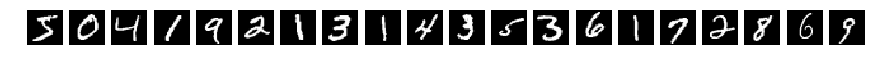

In [6]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [7]:
X = x_train[:60000]
y = y_train[:60000]

print (X.shape)
print (y.shape)

(60000, 784)
(60000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [8]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    ########################################
    # TODO: implement the softmax function #
    ########################################
    exps = 1 / (1 + np.exp(-z))
    return exps / exps.sum(axis=1)[:,None]

def predict(weights, X):
    ###################################
    # TODO: compute the probabilities #
    ###################################
    z = np.dot(X, weights)
    return softmax(z)

def multiclass_log_loss(y, predictions):
    return -(np.log(predictions).reshape(-1, 1) * y.reshape(-1, 1)).mean()

def compute_loss_and_gradients(weights, X, y, l2_reg):
    #############################################################################
    # TODO: compute loss and gradients, don't forget to include regularization! #
    #############################################################################
    predictions = predict(weights, X)
    loss = multiclass_log_loss(y, predictions)
    grad = - (np.dot(X.T, (y - predictions))) / len(y) + 2 * l2_reg * weights
    return loss, grad


We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

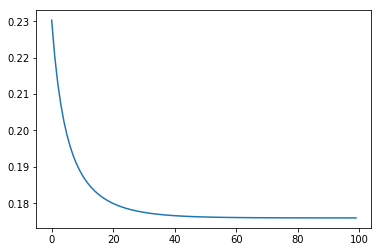

In [9]:
l2_reg = 0.18
n_epochs = 100
lr = 0.2

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [10]:
##############################
# TODO: compute the accuracy #
##############################
# around 80% accuracy is possible

prediction_test = predict(weights, x_test)

prediction_class = np.fromiter( map(lambda x: max(zip(x, range(len(x))))[1], prediction_test), dtype=int)
y_test_class = np.fromiter( map(lambda x: max(zip(x, range(len(x))))[1], y_test), dtype=int)
prediction_result = sum(map(lambda x: x[0] == x[1], zip(prediction_class, y_test_class)))

print(prediction_result / len(y_test) * 100)

76.09


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

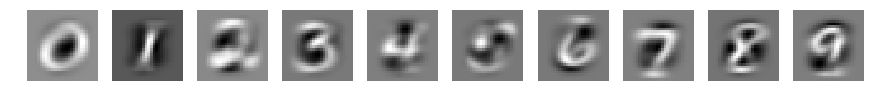

In [11]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [ ]:
################################################
# TODO: implement the proper training pipeline #
################################################